# Solve for $N_g$ in the Transcendental Equation
This notebook numerically solves for $N_g$ in
$$
\ln(1-\epsilon)[\alpha e^{-f}+\beta e^{-\kappa N_g}+E_{\mathrm{gs}}]= -\alpha e^{-f}\mu_0\Delta\left[\frac{N_g(1+\lambda)-100}{N_g^2(N_g-100)^{\lambda+1}}\right]+\beta\kappa e^{-\kappa N_g}.
$$

## 1) Define Parameters and Equation
Set constants and restate the equation to solve for $N_g$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import root_scalar, fsolve, minimize_scalar

# Parameters (edit these)
params = {
    "epsilon": 1e-5,
    "alpha": 2.0,
    "beta": 4.0,
    "kappa": 1e-2,
    "E_gs": -7.711545013271975,
    "mu0": 0.78,
    "Delta": 5e4,
    "lam": 0.58,
}

params

{'epsilon': 1e-05,
 'alpha': 2.0,
 'beta': 4.0,
 'kappa': 0.01,
 'E_gs': -7.711545013271975,
 'mu0': 0.78,
 'Delta': 50000.0,
 'lam': 0.58}

## 2) Implement Residual Function
The residual is LHS - RHS. We enforce $N_g>100$ and $1-\epsilon>0$.

In [2]:
def residual_ng(Ng, p):
    eps = p["epsilon"]
    alpha = p["alpha"]
    beta = p["beta"]
    kappa = p["kappa"]
    E_gs = p["E_gs"]
    mu0 = p["mu0"]
    Delta = p["Delta"]
    lam = p["lam"]

    if Ng <= 100:
        return np.nan
    if 1 - eps <= 0:
        return np.nan

    # f(N_g) = mu0 * Delta / (N_g * (N_g - 100)^lam)
    f_ng = (mu0 * Delta) / (Ng * (Ng - 100) ** lam)

    lhs = np.log(1 - eps) * (alpha * np.exp(-f_ng) + beta * np.exp(-kappa * Ng) + E_gs)
    rhs = -alpha * np.exp(-f_ng) * mu0 * Delta * (
        (Ng * (1 + lam) - 100) / (Ng**2 * (Ng - 100) ** (lam + 1))
    ) + beta * kappa * np.exp(-kappa * Ng)

    return lhs - rhs

# quick check
residual_ng(200.0, params)

-0.005341305732376157

## 3) Solve for $N_g$ with Root Finding
We scan for a sign change to bracket a root, then use `root_scalar`. If no bracket is found, we fall back to `fsolve`.

In [3]:
def solve_ng_for_delta(delta, p):
    """
    Solve for N_g given a fixed Delta.
    Returns N_g or np.nan if no solution found.
    """
    p_delta = dict(p)
    p_delta["Delta"] = delta

    # Search range for N_g
    ng_min = 110.0
    ng_max = min(1.0e8, delta)

    # Attempt to bracket a root
    grid = np.logspace(np.log10(ng_min), np.log10(ng_max), 200)
    res = np.array([residual_ng(x, p_delta) for x in grid])

    bracket = None
    for i in range(len(grid) - 1):
        if np.isfinite(res[i]) and np.isfinite(res[i + 1]) and res[i] * res[i + 1] < 0:
            bracket = (grid[i], grid[i + 1])
            break

    if bracket:
        sol = root_scalar(lambda x: residual_ng(x, p_delta), bracket=bracket, method="brentq")
        return sol.root if sol.converged else np.nan
    else:
        # Fallback to fsolve with an initial guess
        guess = 200.0
        sol = fsolve(lambda x: residual_ng(x, p_delta), guess, full_output=True)
        return sol[0][0] if sol[2] == 1 else np.nan

# Test
solve_ng_for_delta(5e4, params)

384.8734052133976

## 4) Sweep over $\Delta$
Solve for $N_g$ for a range of $\Delta$ values.

Solved 100 out of 100 points


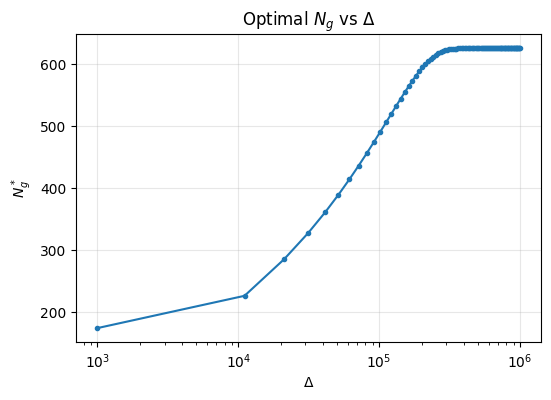

In [4]:
# Define Delta range
D_sweep = np.linspace(1.0e3, 1.0e6, 100)

# Solve for each Delta
Ng_solutions = np.array([solve_ng_for_delta(d, params) for d in D_sweep], dtype=float)

# Filter out NaNs for plotting
mask = np.isfinite(Ng_solutions)
print(f"Solved {mask.sum()} out of {len(D_sweep)} points")

# Quick plot
plt.figure(figsize=(6, 4))
plt.plot(D_sweep[mask], Ng_solutions[mask], 'o-', markersize=3)
plt.xscale('log')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$N_g^*$')
plt.title('Optimal $N_g$ vs $\Delta$')
plt.grid(alpha=0.3)
plt.show()

## 5) Plot with Multiple $\epsilon$ Values and Low-Noise Balance
Compare exact solutions for different noise rates with the low-noise approximation, clearly marking where the approximation breaks down.

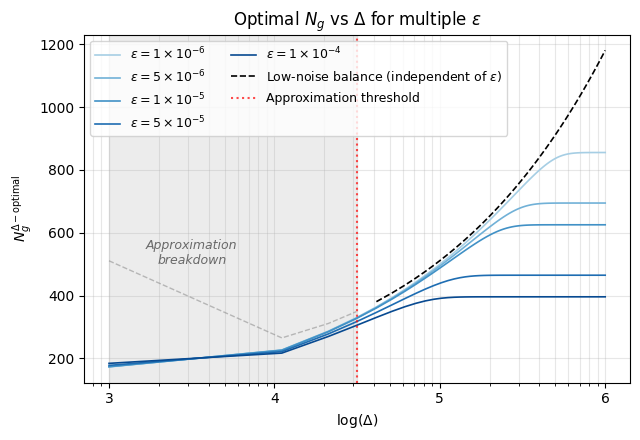


Solved points per epsilon:
  ε = 1e-06: 100/100 points
  ε = 5e-06: 100/100 points
  ε = 1e-05: 100/100 points
  ε = 5e-05: 100/100 points
  ε = 1e-04: 100/100 points


In [ ]:
# Epsilon values (from the figure)
eps_list = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]

# Define where low-noise approximation breaks down
# Based on analysis: kappa*Ng should be << f(Ng)
DELTA_CUTOFF = 10**4.5  # Approximation valid for Delta > this value

# Ensure Delta sweep exists
if "D_sweep" not in globals():
    D_sweep = np.linspace(1.0e3, 1.0e6, 1000)

colors = plt.cm.Blues(np.linspace(0.35, 0.9, len(eps_list)))

plt.figure(figsize=(6.5, 4.5))
solved_counts = []

# Shade the region where low-noise approximation breaks down
plt.axvspan(D_sweep[0], DELTA_CUTOFF, alpha=0.15, color='gray', zorder=0)

# Plot exact solutions for each epsilon
for color, eps in zip(colors, eps_list):
    p_eps = dict(params)
    p_eps["epsilon"] = eps
    Ng_eps = np.array([solve_ng_for_delta(d, p_eps) for d in D_sweep], dtype=float)
    mask = np.isfinite(Ng_eps)

    coef, exp = "{:.0e}".format(eps).split("e")
    label = rf"$\epsilon = {coef} \times 10^{{{int(exp)}}}$"
    plt.plot(D_sweep[mask], Ng_eps[mask], color=color, linewidth=1.2, label=label)

    solved_counts.append((eps, int(mask.sum())))

# Low-noise balance curve (independent of epsilon)
def balance_residual(Ng, delta, p):
    """Low-noise balance equation: alpha*exp(-f)*(1+lambda)*mu0*Delta/Ng^(2+lambda) = beta*kappa*exp(-kappa*Ng)"""
    if Ng <= 100:
        return np.nan
    mu0 = p["mu0"]
    lam = p["lam"]
    alpha = p["alpha"]
    beta = p["beta"]
    kappa = p["kappa"]

    f_ng = (mu0 * delta) / (Ng * (Ng - 100) ** lam)
    lhs = alpha * np.exp(-f_ng) * (1 + lam) * mu0 * delta / (Ng ** (2 + lam))
    rhs = beta * kappa * np.exp(-kappa * Ng)
    return lhs - rhs

p_base = dict(params)
Ng_balance = []
for d in D_sweep:
    if d <= 100:
        Ng_balance.append(np.nan)
        continue
    ng_min = 110.0
    ng_max = min(1.0e8, d)

    grid = np.logspace(np.log10(ng_min), np.log10(ng_max), 200)
    res = np.array([balance_residual(x, d, p_base) for x in grid])
    bracket = None
    for i in range(len(grid) - 1):
        if np.isfinite(res[i]) and np.isfinite(res[i + 1]) and res[i] * res[i + 1] < 0:
            bracket = (grid[i], grid[i + 1])
            break

    if bracket:
        sol = root_scalar(lambda x: balance_residual(x, d, p_base), bracket=bracket, method="brentq")
        Ng_balance.append(sol.root if sol.converged else np.nan)
    else:
        sol = minimize_scalar(lambda x: abs(balance_residual(x, d, p_base)), bounds=(ng_min, ng_max), method="bounded")
        Ng_balance.append(sol.x if sol.success else np.nan)

Ng_balance = np.array(Ng_balance, dtype=float)
mask_b = np.isfinite(Ng_balance)

# Split low-noise balance into valid and invalid regions
mask_valid = (D_sweep[mask_b] >= DELTA_CUTOFF)
mask_invalid = (D_sweep[mask_b] < DELTA_CUTOFF)

# Plot invalid region (dashed/faded)
if np.any(mask_invalid):
    plt.plot(D_sweep[mask_b][mask_invalid], Ng_balance[mask_b][mask_invalid], 
             color="gray", linestyle="--", linewidth=1.0, alpha=0.5)

# Plot valid region (solid)
if np.any(mask_valid):
    plt.plot(D_sweep[mask_b][mask_valid], Ng_balance[mask_b][mask_valid], 
             color="black", linestyle="--", linewidth=1.2,
             label=r"Low-noise balance (independent of $\epsilon$)")

# Add vertical line at cutoff
plt.axvline(DELTA_CUTOFF, color='red', linestyle=':', linewidth=1.5, 
            alpha=0.7, label=r'Approximation threshold')

# Add annotation explaining the breakdown
plt.annotate('Approximation\nbreakdown', xy=(10**3.5, 500), 
             fontsize=12, ha='center', color='dimgray', style='italic')

# Format axes
ax = plt.gca()
ax.set_xscale("log")
ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0))
ax.xaxis.set_major_formatter(mticker.LogFormatterExponent(base=10))
ax.xaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1))

plt.xlabel(r"$\log(\Delta$)", fontsize=13)
plt.ylabel(r"$N_g^{\Delta-\mathrm{optimal}}$", fontsize=13)
plt.title(r"Optimal $N_g$ vs $\Delta$ for multiple $\epsilon$", fontsize=14)
plt.grid(alpha=0.3, which="both")
ax.tick_params(axis='both', which='major', labelsize=11)
plt.legend(ncol=2, fontsize=11, loc = 'upper left')
plt.tight_layout()
plt.savefig("Figs/optimal_ng_delta.pdf", bbox_inches='tight', dpi=300)
plt.show()

print("\nSolved points per epsilon:")
for eps, count in solved_counts:
    print(f"  ε = {eps:.0e}: {count}/{len(D_sweep)} points")

## 6) Breakdown Analysis
Verify why the low-noise approximation breaks down at low $\Delta$.

In [6]:
# Show breakdown analysis
print("Breakdown Analysis:")
print(f"Cutoff Delta: {DELTA_CUTOFF:.1e}")
print(f"Condition for validity: κN_g << f(N_g) = μ₀Δ/N_g^(1+λ)\n")

# Test at low Delta (breakdown region)
print("At Δ = 1e3 (breakdown region):")
Ng_test_low = solve_ng_for_delta(1e3, params)
if np.isfinite(Ng_test_low):
    f_test_low = params['mu0'] * 1e3 / (Ng_test_low * (Ng_test_low - 100)**params['lam'])
    kappa_Ng_low = params['kappa'] * Ng_test_low
    print(f"  N_g = {Ng_test_low:.1f}")
    print(f"  κN_g = {kappa_Ng_low:.3f}")
    print(f"  f(N_g) = {f_test_low:.3f}")
    print(f"  Ratio κN_g/f(N_g) = {kappa_Ng_low/f_test_low:.2f} (should be << 1 for approximation to hold)")
    print(f"  → Approximation INVALID\n")

# Test at high Delta (valid region)
print("At Δ = 1e5 (valid region):")
Ng_test_high = solve_ng_for_delta(1e5, params)
if np.isfinite(Ng_test_high):
    f_test_high = params['mu0'] * 1e5 / (Ng_test_high * (Ng_test_high - 100)**params['lam'])
    kappa_Ng_high = params['kappa'] * Ng_test_high
    print(f"  N_g = {Ng_test_high:.1f}")
    print(f"  κN_g = {kappa_Ng_high:.3f}")
    print(f"  f(N_g) = {f_test_high:.3f}")
    print(f"  Ratio κN_g/f(N_g) = {kappa_Ng_high/f_test_high:.2f} (should be << 1 for approximation to hold)")
    print(f"  → Approximation VALID")

Breakdown Analysis:
Cutoff Delta: 3.2e+04
Condition for validity: κN_g << f(N_g) = μ₀Δ/N_g^(1+λ)

At Δ = 1e3 (breakdown region):
  N_g = 173.5
  κN_g = 1.735
  f(N_g) = 0.372
  Ratio κN_g/f(N_g) = 4.67 (should be << 1 for approximation to hold)
  → Approximation INVALID

At Δ = 1e5 (valid region):
  N_g = 487.2
  κN_g = 4.872
  f(N_g) = 5.051
  Ratio κN_g/f(N_g) = 0.96 (should be << 1 for approximation to hold)
  → Approximation VALID
